# Initializing

In [1]:
#Active environment should be aws_env
!conda info | grep 'active env'

     active environment : aws_env
    active env location : /home/hassan101/anaconda3/envs/aws_env


In [2]:
#Get AWS credentials from environment
import os
aws_akid = os.environ['AWS_KID']
aws_sak = os.environ['AWS_AK']

In [3]:
#Importing libraries
import boto3
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Getting processed data from S3 bucket

In [4]:
#Authentication
res_s3 = boto3.resource('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak)
client_s3 = boto3.client('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak) 

In [5]:
# List all objects in bucket
bucket_name = 'reg-dataset-processed'

response = client_s3.list_objects_v2(Bucket=bucket_name)
for obj in response['Contents']:
    print(obj)

{'Key': 'lifexp-processed.csv', 'LastModified': datetime.datetime(2023, 2, 9, 9, 16, 24, tzinfo=tzutc()), 'ETag': '"9e138a0af6f65a9b4338da770613527c"', 'Size': 98812, 'StorageClass': 'STANDARD'}


In [6]:
response = client_s3.get_object(Bucket=bucket_name, Key="lifexp-processed.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df = pd.read_csv(response.get("Body"))
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200


In [7]:
df.head(20)

,HIV/AIDS,Income composition of resources,Adult mortality,Under-five deaths,Thinness 5-9 years,Status,Polio,Total expenditure
0,0.1,0.479,263,83,17.3,Developing,6,8.16
1,0.1,0.476,271,86,17.5,Developing,58,8.18
2,0.1,0.470,268,89,17.7,Developing,62,8.13
3,0.1,0.463,272,93,18.0,Developing,67,8.52
4,0.1,0.454,275,97,18.2,Developing,68,7.87
5,0.1,0.448,279,102,18.4,Developing,66,9.20
6,0.1,0.434,281,106,18.7,Developing,63,9.42
7,0.1,0.433,287,110,18.9,Developing,64,8.33
8,0.1,0.415,295,113,19.1,Developing,63,6.73
9,0.1,0.405,295,116,19.3,Developing,58,7.43


In [8]:
df.dtypes

HIV/AIDS                           float64
Income composition of resources    float64
Adult mortality                      int64
Under-five deaths                    int64
Thinness 5-9 years                 float64
Status                              object
Polio                                int64
Total expenditure                  float64
dtype: object

# Feature engineering

We need to perform these things:
- Seperate feature and target values
- OHE
- Train/Test split
- Pipeline:
    - Scaling
    - ML dev

In [9]:
#Seperate feature and labels
X=df.iloc[:,:-1]
y=df.iloc[:,[-1]]
print(X.shape)
print(y.shape)

(2556, 7)
(2556, 1)


In [10]:
#Perform OHE
X_ohe = pd.get_dummies(X)
print(X_ohe.shape)
X_ohe.head()

(2556, 8)


,HIV/AIDS,Income composition of resources,Adult mortality,Under-five deaths,Thinness 5-9 years,Polio,Status_Developed,Status_Developing
0,0.1,0.479,263,83,17.3,6,0,1
1,0.1,0.476,271,86,17.5,58,0,1
2,0.1,0.470,268,89,17.7,62,0,1
3,0.1,0.463,272,93,18.0,67,0,1
4,0.1,0.454,275,97,18.2,68,0,1


# Training via pipelienes

In [130]:
#Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=1)

In [115]:
#Setup MLDev pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

mldev_pipeline = {
    'linreg': make_pipeline(StandardScaler(), LinearRegression()),
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor())
}

for model_name, pipeline in mldev_pipeline.items():
    print(model_name)
    print(pipeline)

linreg
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
rf
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])
gb
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])


In [116]:
#These can also be viewed visually
mldev_pipeline['linreg']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [117]:
#Check the parameters for these models
print('LinReg Params:',LinearRegression().get_params())
print('RF Params:',RandomForestRegressor().get_params())
print('GB Params:',GradientBoostingRegressor().get_params())

LinReg Params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
RF Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
GB Params: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [118]:
#Create a grid for hyperparameters tuning
hpgrid = {

    'linreg':{
    },
    
    'rf':{
        'randomforestregressor__n_estimators':[100, 200, 300],
        'randomforestregressor__max_depth':[5, 10, 'None']
    },

    'gb':{
        'gradientboostingregressor__n_estimators':[100,200,300],
        'gradientboostingregressor__learning_rate':[0.1, 0.2],
    }
}

In [119]:
#Training the models by looping across pipeline
from sklearn.model_selection import GridSearchCV

trained_models = {}
for model_name, pipeline in mldev_pipeline.items():
    #Train using CV class
    print(f'Training model: {model_name}')
    model = GridSearchCV(pipeline, hpgrid[model_name], n_jobs = -1, cv = 10) #n_jobs = -1 will use all processors for parallel computing
    model.fit(X_train, y_train.values.ravel())
    trained_models[model_name] = model

trained_models

Training model: linreg
Training model: rf


/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/ense

Training model: gb


{'linreg': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('linearregression',
                                         LinearRegression())]),
              n_jobs=-1, param_grid={}),
 'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('randomforestregressor',
                                         RandomForestRegressor())]),
              n_jobs=-1,
              param_grid={'randomforestregressor__max_depth': [5, 10, 'None'],
                          'randomforestregressor__n_estimators': [100, 200,
                                                                  300]}),
 'gb': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('gradientboostingregressor',
                                         GradientBoostin

In [120]:
# Check metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

for model_name, model in trained_models.items():
    y_hat = model.predict(X_test)
    print(f'Metrics for {model_name}:',
    'MAE=', mean_absolute_error(y_test,y_hat),
    'RMSE=', mean_squared_error(y_test,y_hat, squared=False),
    'R2=', r2_score(y_test,y_hat)    
    )

Metrics for linreg: MAE= 1.6699640111064518 RMSE= 2.1968312349736343 R2= 0.13169417409574824
Metrics for rf: MAE= 1.063902702425391 RMSE= 1.6134598781937508 R2= 0.5316228864103718
Metrics for gb: MAE= 1.2189985088237254 RMSE= 1.7703256299334895 R2= 0.43612136583006245


In [121]:
#Checking parameters for the best model
trained_models['rf'].get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('standardscaler', StandardScaler()),
  ('randomforestregressor', RandomForestRegressor())],
 'estimator__verbose': False,
 'estimator__standardscaler': StandardScaler(),
 'estimator__randomforestregressor': RandomForestRegressor(),
 'estimator__standardscaler__copy': True,
 'estimator__standardscaler__with_mean': True,
 'estimator__standardscaler__with_std': True,
 'estimator__randomforestregressor__bootstrap': True,
 'estimator__randomforestregressor__ccp_alpha': 0.0,
 'estimator__randomforestregressor__criterion': 'squared_error',
 'estimator__randomforestregressor__max_depth': None,
 'estimator__randomforestregressor__max_features': 1.0,
 'estimator__randomforestregressor__max_leaf_nodes': None,
 'estimator__randomforestregressor__max_samples': None,
 'estimator__randomforestregressor__min_impurity_decrease': 0.0,
 'estimator__randomforestregressor__min_samples_leaf': 1,
 'estimator__randomforestregre

In [122]:
# Saving best model
import pickle
with open('bestmodel.pkl', 'wb') as f:
    pickle.dump(trained_models['rf'], f)

In [123]:
#If we need to reload the model in future, we can use this code
with open('bestmodel.pkl', 'rb') as f:
    reloaded_model = pickle.load(f)

reloaded_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 10, 'None'],
                         'randomforestregressor__n_estimators': [100, 200,
                                                                 300]})

# Training from scratch

In [11]:
#Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=1)

In [13]:
#Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rfreg = RandomForestRegressor()
rfreg.fit(scaler.transform(X_train), y_train.values.ravel())
scores = cross_val_score(rfreg, scaler.transform(X_train), y_train.values.ravel(), cv=10)
scores

array([0.32891931, 0.44328858, 0.46548202, 0.32761007, 0.4725555 ,
       0.39019201, 0.357765  , 0.51709193, 0.35418124, 0.42552547])

In [15]:
# Check metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
y_hat = rfreg.predict(scaler.transform(X_test))
print('MAE=', mean_absolute_error(y_test,y_hat),
'RMSE=', mean_squared_error(y_test,y_hat, squared=False),
'R2=', r2_score(y_test,y_hat)
)

MAE= 0.9010989569752279 RMSE= 1.4951781523142174 R2= 0.5977785658108694


In [16]:
r2_adj = 1 - (1-r2_score(y_test,y_hat))*(len(y_hat)-1)/(len(y_hat)-len(X_test.columns)-1)
r2_adj

0.593533484711248

In [17]:
rfreg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
# Saving model
import pickle
#with open('model_fromscratch.pkl', 'wb') as f:
#    pickle.dump(rfreg, f)

pickle.dump(rfreg, open('model_fromscratch.pkl', 'wb'))

In [19]:
# Saving standardization params
pickle.dump(scaler, open('scaling.pkl','wb'))

In [200]:
#If above training does not work, check optimal train test split by this:

for i in range(0,10):
    print('----------------------------------------------------------')
    print('Random state for split=', i)
    X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=i)

    scaler = StandardScaler()
    scaler.fit(X_train)

    rfreg = RandomForestRegressor()
    rfreg.fit(scaler.transform(X_train), y_train.values.ravel())
    scores = cross_val_score(rfreg, scaler.transform(X_train), y_train.values.ravel(), cv=10)
    print(scores)
    from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
    y_hat = rfreg.predict(scaler.transform(X_test))
    print('MAE=', mean_absolute_error(y_test,y_hat),
    'RMSE=', mean_squared_error(y_test,y_hat, squared=False),
    'R2=', r2_score(y_test,y_hat)
    )

----------------------------------------------------------
Random state for split= 0
[0.63234219 0.51386384 0.4702484  0.56169044 0.31116636 0.30248144
 0.56065081 0.51109162 0.61874021 0.53961243]
MAE= 0.9410745958279008 RMSE= 1.571019482447298 R2= 0.544493458631602
----------------------------------------------------------
Random state for split= 1
[0.32356344 0.42855375 0.49121862 0.30529649 0.46330428 0.41117117
 0.35582655 0.49747661 0.31960854 0.43985278]
MAE= 0.9231406779661014 RMSE= 1.516618252019882 R2= 0.5861605560651906
----------------------------------------------------------
Random state for split= 2
[0.54419395 0.58309583 0.29858854 0.60920058 0.46762007 0.46304989
 0.47306549 0.33216896 0.48981248 0.33648692]
MAE= 1.0664510126032158 RMSE= 1.7684370948466688 R2= 0.4966131413463647
----------------------------------------------------------
Random state for split= 3
[0.4422677  0.35792815 0.32080908 0.51734797 0.59051987 0.71258469
 0.36889126 0.51799623 0.43725981 0.48061

# Plotting the predictions

Text(0, 0.5, 'Predicted Life Expectancy')

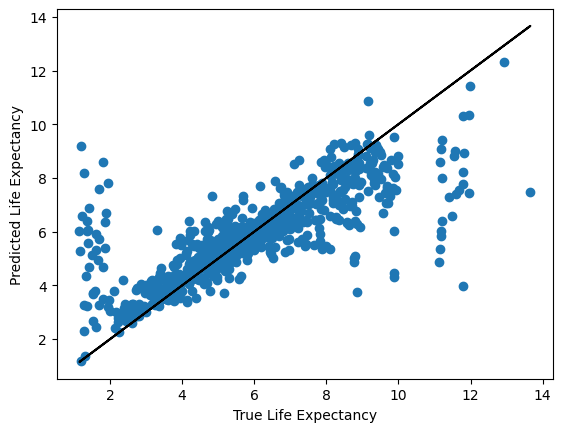

In [168]:
#Plotting parity plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_test, y_hat)
plt.plot(y_test,y_test,'k-') 
plt.xlabel('True Life Expectancy')
plt.ylabel('Predicted Life Expectancy')

Text(0.5, 9.444444444444438, 'Residuals')

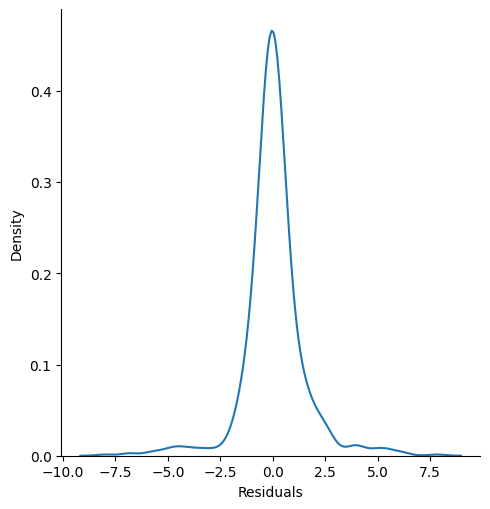

In [169]:
#Plotting residuals
import seaborn as sns

residuals = y_test.values.ravel() - y_hat
sns.displot(residuals, kind = 'kde')
plt.xlabel('Residuals')

Text(0, 0.5, 'Residuals')

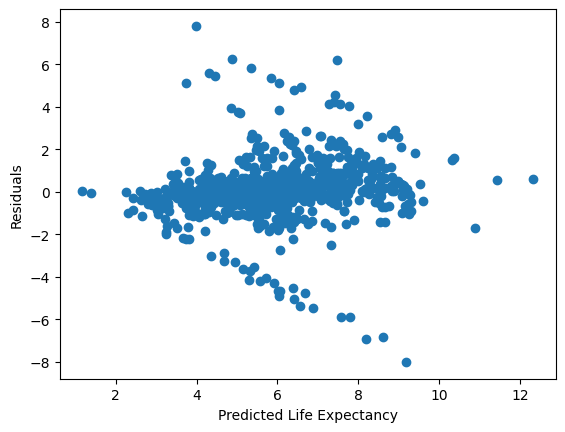

In [174]:
# Plotting scatter plot for residuals and predictions
plt.scatter(y_hat, residuals)
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals')

# Testing for app

In [106]:
#Testing with sample data

print('Actual label for data:', y_train.iloc[0]['Total expenditure'])
print(f'These are the features with data shape:{X_train.iloc[0:1,:].shape}')
X_train.iloc[0:1,:].head()

Actual label for data: 2.37
These are the features with data shape:(1, 8)


,HIV/AIDS,Income composition of resources,Adult mortality,Under-five deaths,Thinness 5-9 years,Polio,Status_Developed,Status_Developing
1077,0.1,0.624,213,237,1.9,79,0,1


In [107]:
#Predicting with script (passing without additional header)
model = pickle.load( open('model_fromscratch.pkl', 'rb') )
scaler = pickle.load( open('scaling.pkl', 'rb') )

import json
import numpy as np

#Preparing data in form of JSON
dic = {
		"HIV/AIDS": 0.1,
		"Income composition of resources": 0.624,
		"Adult mortality": 213.0,
		"Under-five deaths": 237.0,
		"Thinness 5-9 years": 1.9,
		"Polio": 79.0,
		"Status_Developed": 0.0,
		"Status_Developing": 1.0
	}
data_as_json=json.dumps(dic)
data_as_json

#Loading JSON data on the app, and transforming for predictions
data_as_dic = json.loads(data_as_json)
data_as_array = np.array(list(data_as_dic.values())).reshape(1,-1)
print('Data shape:', data_as_array.shape)
data_sc=scaler.transform(data_as_array)
output=model.predict(data_sc)
print('Predicted value:', output[0])

Data shape: (1, 8)
Predicted value: 2.5392000000000023


/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [108]:
#Predicting with script (passing with additional "data"" header)
model = pickle.load( open('model_fromscratch.pkl', 'rb') )
scaler = pickle.load( open('scaling.pkl', 'rb') )

import json
import numpy as np

#Preparing data in form of JSON
dic = {
    "data":{
		"HIV/AIDS": 0.1,
		"Income composition of resources": 0.624,
		"Adult mortality": 213.0,
		"Under-five deaths": 237.0,
		"Thinness 5-9 years": 1.9,
		"Polio": 79.0,
		"Status_Developed": 0.0,
		"Status_Developing": 1.0
	}
}
data_as_json=json.dumps(dic['data'])
data_as_json

#Loading JSON data on the app, and transforming for predictions
data_as_dic = json.loads(data_as_json)
data_as_array = np.array(list(data_as_dic.values())).reshape(1,-1)
print('Data shape:', data_as_array.shape)
data_sc=scaler.transform(data_as_array)
output=model.predict(data_sc)
print('Predicted value:', output[0])

Data shape: (1, 8)
Predicted value: 2.5392000000000023


/home/hassan101/anaconda3/envs/aws_env/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
